In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys
import pickle


In [2]:
### Load datamodel from .p file
run_name = 'run1_trap_pzt'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\31\run1_trap_pzt\run1_trap_pzt-datamodel.p


In [3]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [100,102,104,106,108,110,112,114,116,118,120]
num_tweezers = len(tweezer_freq_list)

cav_odt_att_list = [0.3,0.6,0.9] 
pzt_para_list = [5.5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]

num_points = datamodel.num_points #len(pzt_para_list) * len(cav_odt_att_list)


mol_freq_list = [5.5]
mol_freq = 5.5
num_frames = len(pzt_para_list) + 2

num_shots = datamodel.num_shots
# num_shots = 69

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

3 points
12 frames
11 tweezers
2565 shots
855 complete loops


In [4]:
counts_array = np.zeros((num_frames,len(cav_odt_att_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    cav_odt_att_counter = point
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,cav_odt_att_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
            
            
print(counts_array.shape)

good_array = np.zeros((len(cav_odt_att_list),len(tweezer_freq_list),num_loops), dtype=bool)
num_complete_shots = int(num_points*(num_shots//num_points))
for tweezer_counter in range(num_tweezers):
    for shot in range(num_complete_shots):
        point = shot % num_points
        loop = shot // num_points
        cav_odt_att_counter = point 
#         good_array[cav_odt_att_counter, tweezer_counter, loop] = trap_sigma[shot] <0.052
        good_array[cav_odt_att_counter, tweezer_counter, loop] = True
print(good_array.shape)

(12, 3, 11, 855)
(3, 11, 855)


c:\python37-32\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


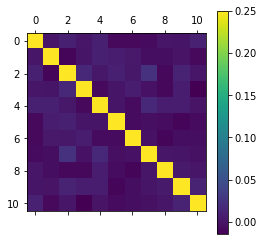

mean_in_theory:5.5, std_in_theory:1.6583123951777
mean:5.521637426900585, std:1.6772818820387947
[0, 1]
[1, 5]
[2, 28]
[3, 64]
[4, 133]
[5, 184]
[6, 189]
[7, 160]
[8, 60]
[9, 28]
[10, 3]
[11, 0]


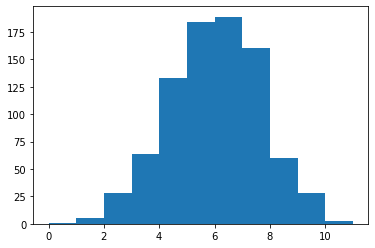

In [5]:
show_plot = False
# zeropeakHWFMper = 1.5
roi_area = 20*12
zeropeakHWFMper = 3
num_avg = 30 # number of loops to put in moving average

# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(pzt_para_list),len(cav_odt_att_list),num_loops))



ref_counts = counts_array[num_frames-2,:,:,:]
ref_sigma = np.nanstd(ref_counts,-1)
ref_mean = np.nanmean(ref_counts,-1)
throw_threshold = ref_mean + 3 * ref_sigma
throw_threshold = np.repeat(throw_threshold[:,:,np.newaxis], num_loops, axis=2)
mask = np.less(ref_counts, throw_threshold, where=~np.isnan(ref_counts))
ref_counts = np.where(mask, ref_counts, np.nan)
base = np.nanmean(ref_counts,-1)

upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,np.newaxis],num_loops,axis=2)
upper_threshold = np.repeat(upper_threshold[:,:,np.newaxis], num_loops, axis=2)

counts_1 = counts_array[0,:,:,:]


for frame_num in range(len(pzt_para_list)):
    pzt_para = pzt_para_list[frame_num]
    counts = counts_array[frame_num,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,-1)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,-1)
    brightness_mean = np.nanmean(brightness,-1)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,np.newaxis], num_loops, axis=2)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
#     print(counts_postpost_selected)
    counts_postpostpost_selected = np.where(good_array, counts_postpost_selected, np.nan)
    
    
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list):
        if show_plot == True:
            fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
            fig.suptitle(f'counts histogram - mol_freq={mol_freq} - cav_odt_att={cav_odt_att} - frame_{frame_num + 1}')

            for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                bins=50
                ax[0,tweezer_freq_counter].hist(counts_1[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                ax[0,tweezer_freq_counter].hist(ref_counts[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                n, bins, patches = \
                ax[0,tweezer_freq_counter].hist(counts[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                ax[0,tweezer_freq_counter].hist(counts_postpostpost_selected[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                ax[0,tweezer_freq_counter].axvline(upper_threshold[cav_odt_att_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                scatter_range = range(num_loops)
                ax[1,tweezer_freq_counter].scatter(scatter_range, counts[cav_odt_att_counter,tweezer_freq_counter,:], color='r')
                ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[cav_odt_att_counter,tweezer_freq_counter,:], color='b')
                ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                ax[1,tweezer_freq_counter].set_ylabel('photon counts')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
            plt.show()
    
    
    has_atom[frame_num,:,:,:] = ~np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:], axis = 1)
    atomcenter = np.nanmean(counts_postpostpost_selected,-1)
    brightness = counts_postpostpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,-1)
    brightness_sigma = np.nanstd(brightness,-1)
    
#     lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,-1)
cav_brightness_sigma = np.nanstd(cav_brightness,-1)
cav_fidelity_mean = np.nanmean(cav_fidelity,-1)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,start_temp:end_temp],-1)
    cav_brightness_mov_sigma[:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,start_temp:end_temp],-1)
    cav_fidelity_mov_avg[:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,start_temp:end_temp],-1)
    cav_fidelity_mov_sigma[:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,start_temp:end_temp],-1)

covariance_matrix = np.zeros((num_tweezers,num_tweezers))
for ii in range(num_tweezers):
    for jj in range(num_tweezers):
        covariance_matrix[ii,jj] = np.cov(has_atom[0,0,ii,:],has_atom[0,0,jj,:])[0,1]
plt.matshow(covariance_matrix)
plt.colorbar()
plt.show()

bins=11
plt.hist(atom_number[0,0,:],bins=bins,range=(0,bins))
print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
print(f"mean:{np.mean(atom_number[0,0,:])}, std:{np.std(atom_number[0,0,:])}")
for number_atom in range(num_tweezers+1):
    print([number_atom, np.count_nonzero(atom_number[0,0,:]==number_atom)])

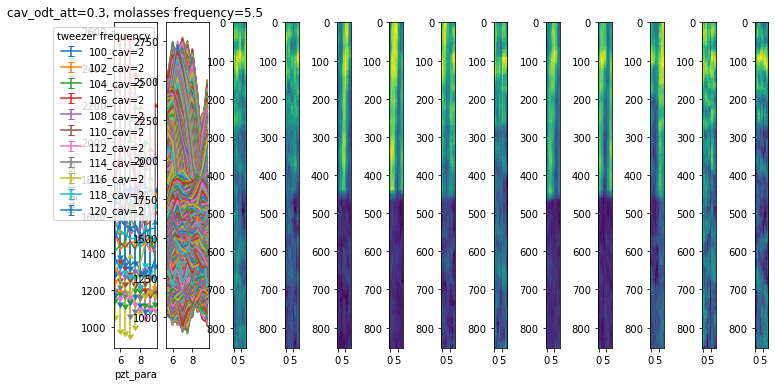

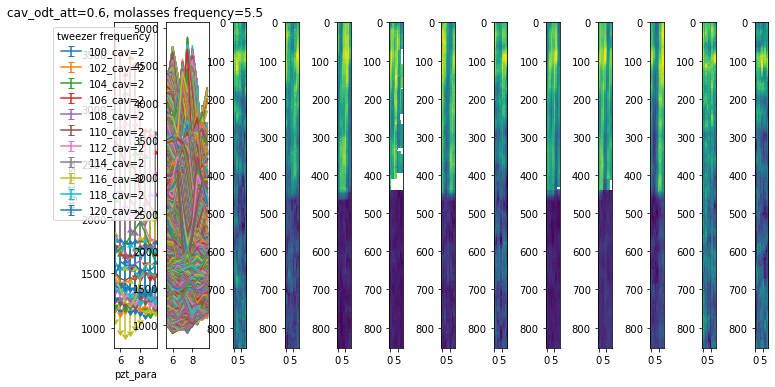

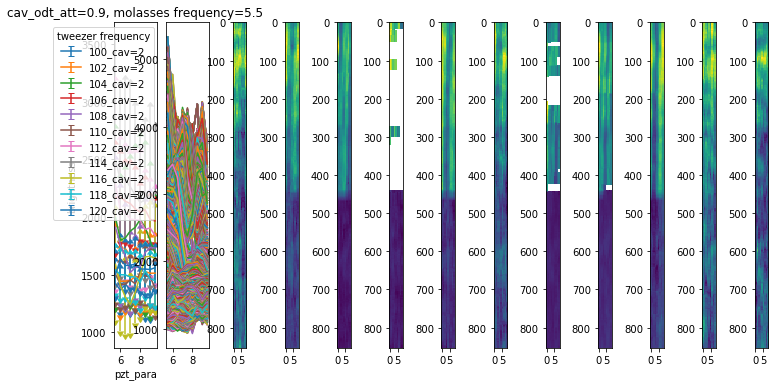

In [6]:
# PICK ONE cav_odt_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: cav_odt_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 

# num_tweezers = 2



for cav_odt_att_counter in range(len(cav_odt_att_list)):
    fig, axs = plt.subplots(1, 2+num_tweezers, figsize=(12, len(mol_freq_list)*6))
    axs[0].set_xlabel('pzt_para')
    axs[0].set_ylabel('brightness')
    cav_odt_att = cav_odt_att_list[cav_odt_att_counter]
    
    axs[0].set_title(f'cav_odt_att={cav_odt_att}, molasses frequency={mol_freq_list[0]}')        
    axs[0].tick_params(axis='y')
    for tweezer_counter in range(num_tweezers):
        axs[0].errorbar(np.array(pzt_para_list)[1:], cav_brightness_mean[1:, cav_odt_att_counter, tweezer_counter], \
            yerr = cav_brightness_sigma[1:, cav_odt_att_counter, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
        for loop in range(0,num_loops,1):
#                 axs[mol_counter,1].plot(np.array(pzt_para_list),np.nanmean(cav_brightness[mol_counter,cav_odt_att_counter,:,tweezer_counter,loop:(loop+25)],1))
            axs[1].plot(np.array(pzt_para_list)[1:],cav_brightness_mov_avg[1:,cav_odt_att_counter,tweezer_counter,loop])
        axs[2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[1:,cav_odt_att_counter,tweezer_counter,:]), aspect = 0.25)
    axs[0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

In [7]:
# using outside tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and cav_odt att. 
outside_tweezer_counter = 10
molasses_intensity_list = [0.97512614, 0.98709936, 0.96621564, 0.99082936, 1. ,        0.93898526,
0.9479187,  0.90025779, 0.89672007, 0.88659351, 0.85702366]

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the cav_odt mode. 

# bg_brightness_mean = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))
bg_brightness_mov_avg = np.zeros(num_loops)
bg_brightness_mov_sigma = np.zeros(num_loops)

cav_brightness_mov_avg_normalized = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
# cav_brightness_mov_sigma_normalized = np.zeros((len(mol_freq_list),len(cav_odt_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

bg_brightness_mean = np.nanmean(cav_brightness_mean[ :, :, outside_tweezer_counter])
bg_brightness_sigma = np.sqrt(np.nanmean(cav_brightness_sigma[:, :, outside_tweezer_counter]**2) \
            + np.nanmean((cav_brightness_mean[:, :, outside_tweezer_counter]-bg_brightness_mean)**2))
for loop in range(num_loops):
    bg_brightness_mov_avg[loop] = np.nanmean(cav_brightness_mov_avg[:, :, outside_tweezer_counter,loop])
    bg_brightness_mov_sigma[loop] = np.sqrt(np.nanmean(cav_brightness_mov_sigma[:, :, outside_tweezer_counter,loop]**2) \
            + np.nanmean((cav_brightness_mov_avg[:, :, outside_tweezer_counter,loop]-bg_brightness_mov_avg[loop])**2))
    for tweezer_counter in range(len(tweezer_freq_list)):
#                 print((bg_brightness_mov_avg[mol_counter, loop]/bg_brightness_mean[mol_counter]))
        cav_brightness_mov_avg_normalized[:, :, tweezer_counter, loop] = \
        cav_brightness_mov_avg[:, :, tweezer_counter, loop]/\
                (bg_brightness_mov_avg[loop]/bg_brightness_mean)\
#                 *(molasses_intensity_list[outside_tweezer_counter]/molasses_intensity_list[tweezer_counter])


bg_fidelity_mean = np.nanmean(cav_fidelity_mean[:, :, outside_tweezer_counter])
bg_fidelity_sigma = np.sqrt(np.nanmean(cav_fidelity_sigma[:, :, outside_tweezer_counter]**2) \
            + np.nanmean((cav_fidelity_mean[:, :, outside_tweezer_counter]-bg_fidelity_mean)**2))


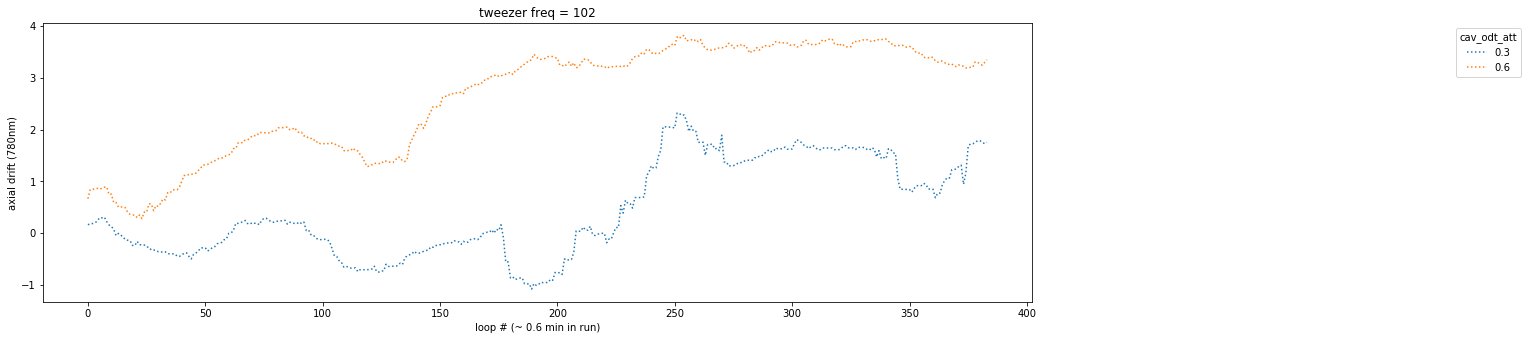

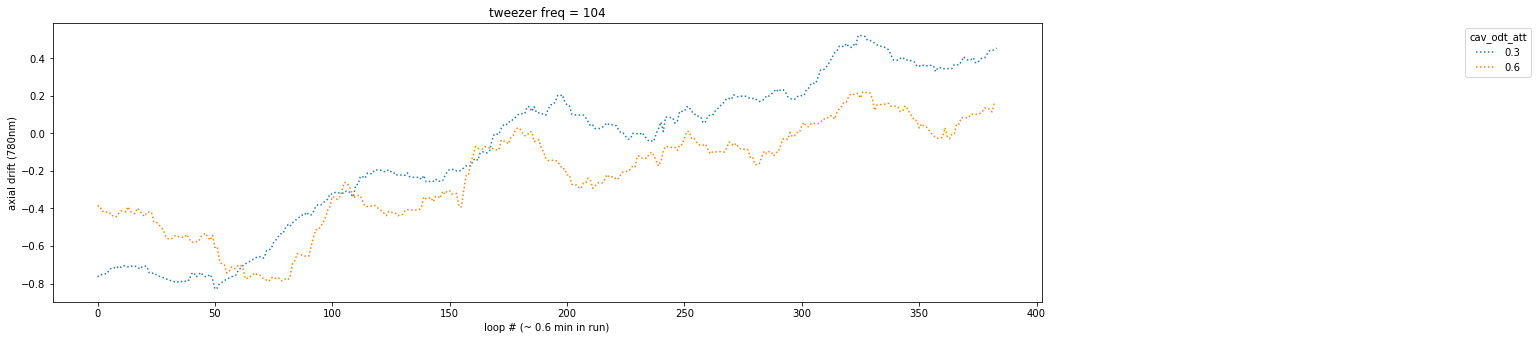

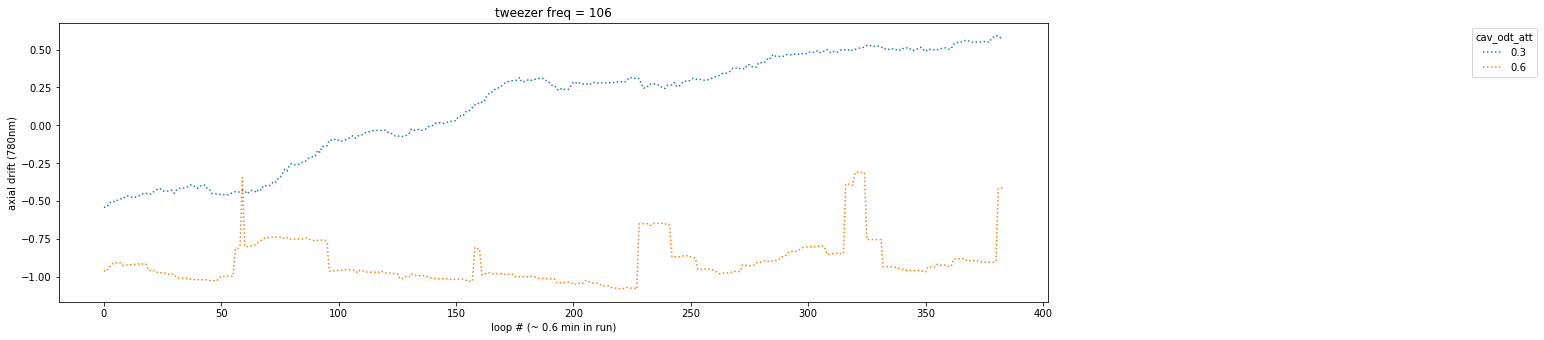

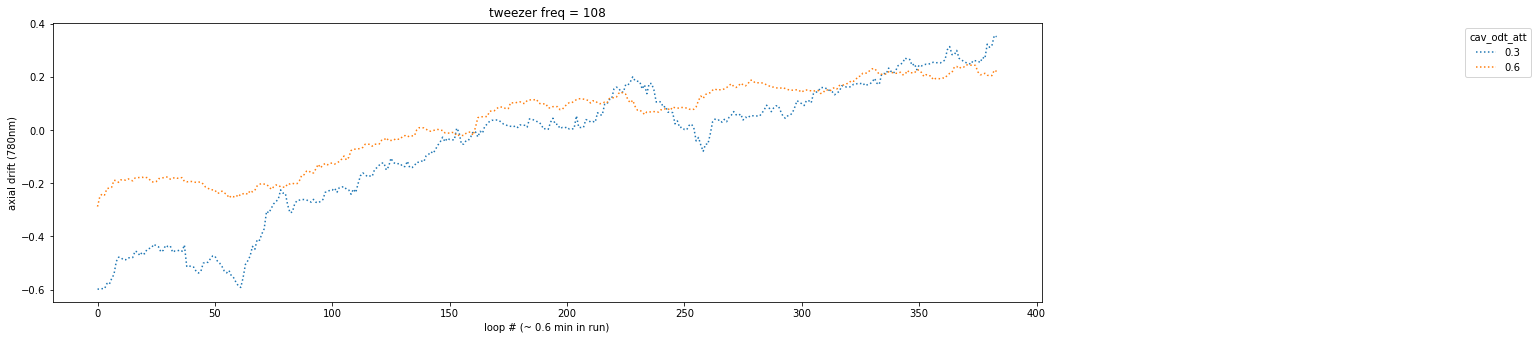

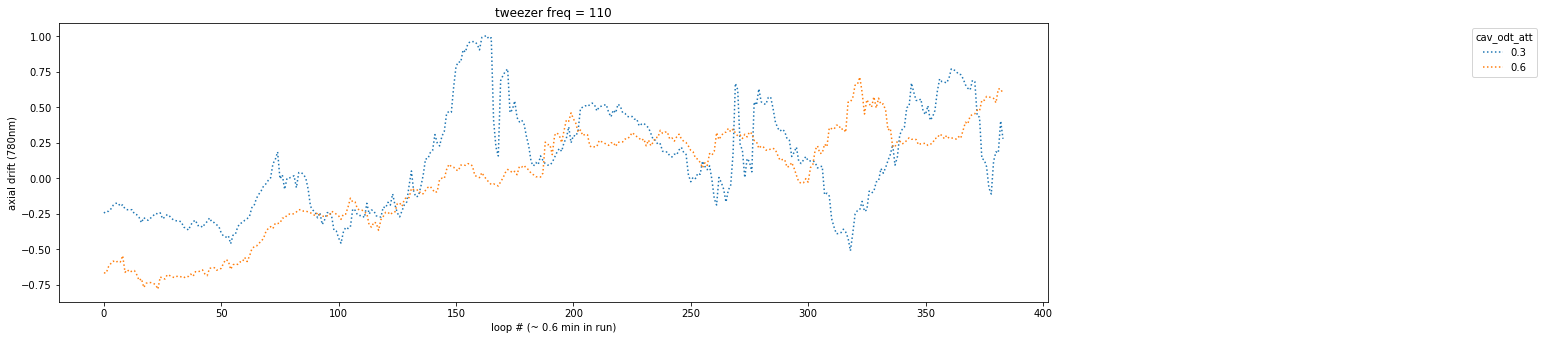

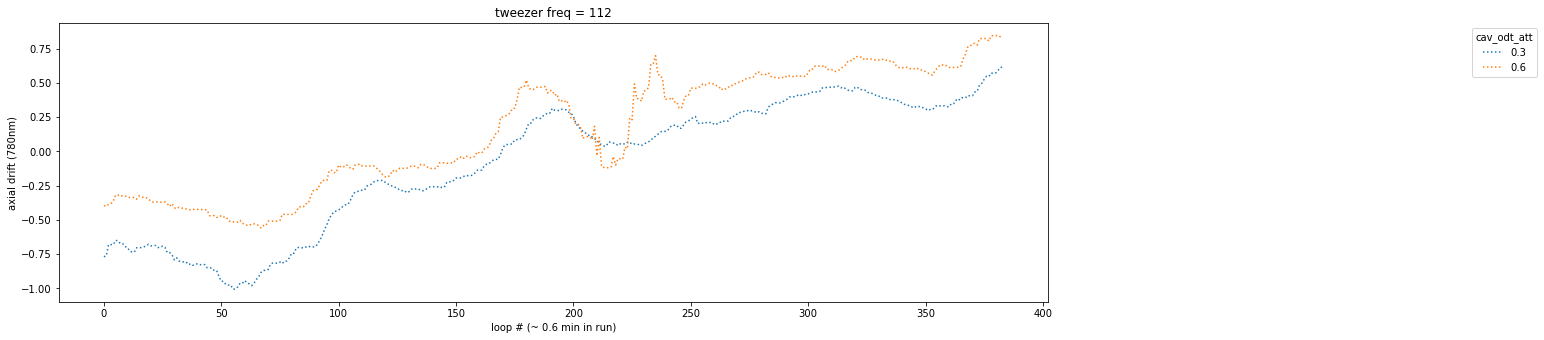

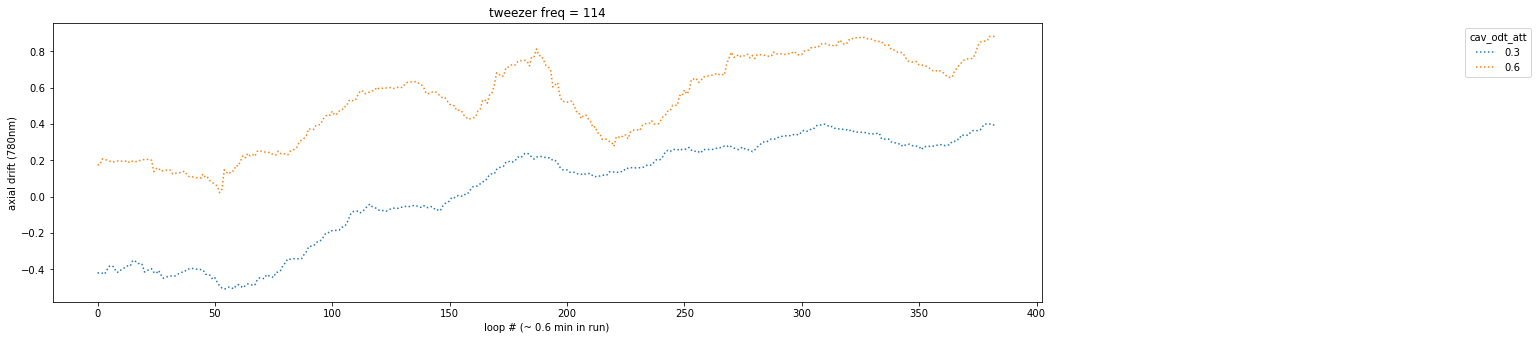

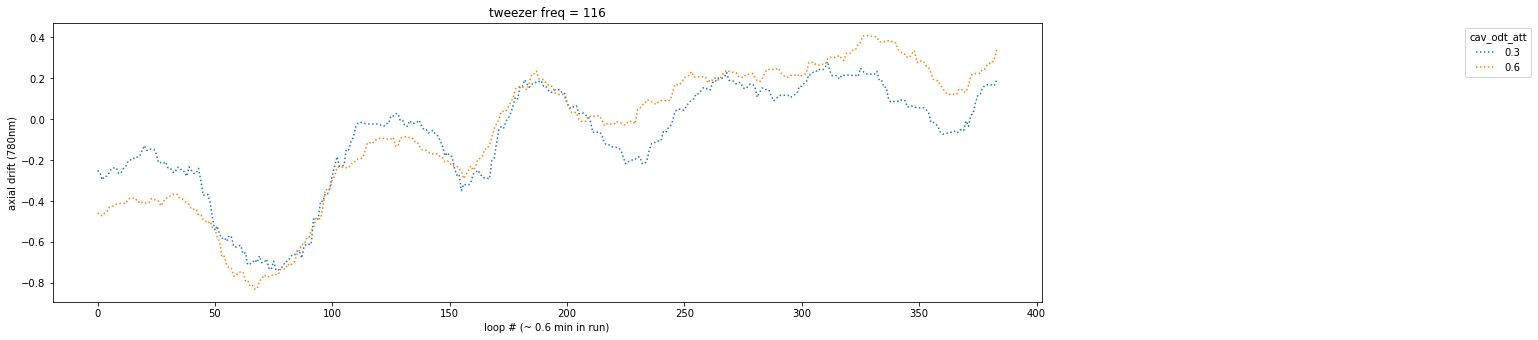

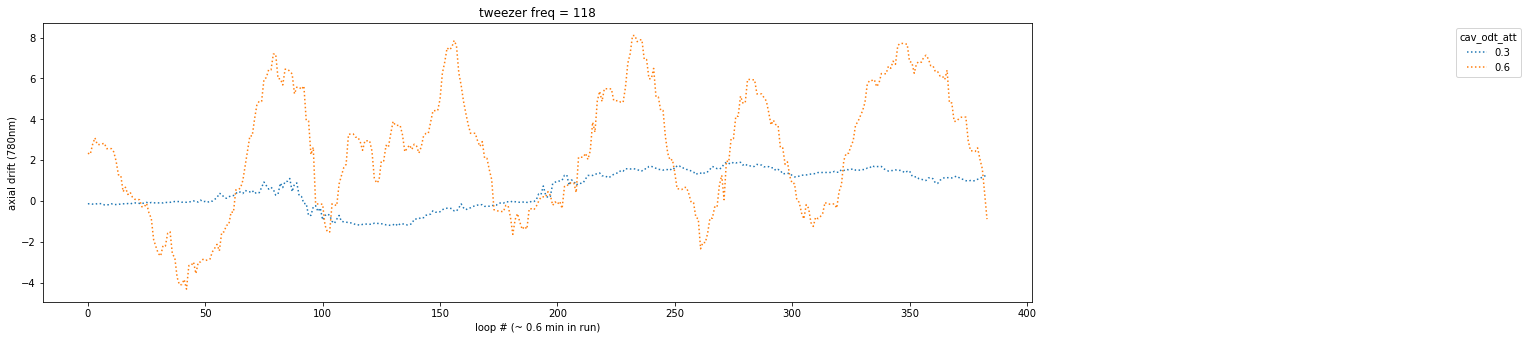

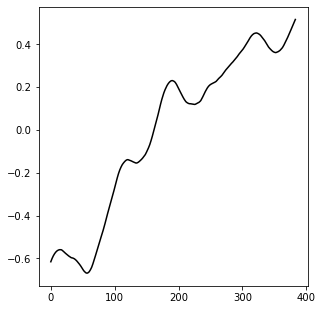

In [8]:


loop_start = num_avg//2+1
loop_end = num_loops - num_avg//2-11
# loop_start = 30
loop_end = 400

shifted_pzt_paras = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
shifted_pzt_para_simple = np.zeros((len(pzt_para_list),num_loops))

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))


y_mag = 1 #13.64
x_mag = 2/7.5


for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:-1]):
        valid = ~(np.isnan(cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter]) |\
                  np.isnan(cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter]))
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                       cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter][valid],\
                       sigma = cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter][valid],\
                       p0=[1000, 4000, 7, 0], maxfev = 10000)

        a0, b0, wavelength0, xshift0 = popt
        def func_cos2(x, xshift, a):
            return b0 + a * np.cos(4*np.pi/wavelength0*(x+xshift)) 
        xshift = xshift0
        a = a0
        for loop in range(loop_start, loop_end):
            ba = cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter,loop]
            pzt_list = np.array(pzt_para_list)[~np.isnan(ba)]
            ba_sig = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter,loop][~np.isnan(ba)]
            ba = ba[~np.isnan(ba)]
            popt, pcov = curve_fit(func_cos2, pzt_list,\
                                   ba,\
        #                            sigma = ba_sig,\
                                   p0=[xshift, a], maxfev = 10000)

            xshift = popt[0]

            shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter,loop] \
            = np.array(pzt_para_list)+xshift-xshift0





for tweezer_counter in range(1,10):
    fig, ax = plt.subplots(1,1,  figsize=(15, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
    for cav_odt_att_counter in range(2):
        y_data = shifted_pzt_paras[5,cav_odt_att_counter,tweezer_counter,loop_start:loop_end]-np.array(pzt_para_list)[5]
        ax.plot(y_data, label= f'{cav_odt_att_list[cav_odt_att_counter]}',ls=':')
#             ax[cav_odt_att_counter].set_ylim([-1,1])
        ax.set_title(f'tweezer freq = {tweezer_freq_list[tweezer_counter]}')

        ax.set_xlabel(f'loop # (~ {(num_points*11/60):.1f} min in run)')
        ax.set_ylabel('axial drift (780nm)')

    ax.legend(title='cav_odt_att', bbox_to_anchor=(1.5, 1), loc='upper right')
    
    
    
    
    
                
from scipy.signal import savgol_filter
center_tweezer_counter_list = [2,3,6,7]
cav_odt_att_counter = 0

shifted_pzt_para_simple[:,loop_start:loop_end] = savgol_filter(np.mean(shifted_pzt_paras[:,cav_odt_att_counter,center_tweezer_counter_list,loop_start:loop_end], axis=1), 35, 3)
# for loop in range(loop_start,loop_end):
#     shifted_pzt_para_simple[:,loop] = np.array(pzt_para_list)
for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:]):
        shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter,loop_start:loop_end] = shifted_pzt_para_simple[:,loop_start:loop_end]
            
        
        
        
for tweezer_counter in range(1):
    fig, ax = plt.subplots(1,1,  figsize=(5, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
        
    for cav_odt_att_counter in range(1):
        y_data = shifted_pzt_paras[0,cav_odt_att_counter,tweezer_counter,loop_start:loop_end]-np.array(pzt_para_list)[0]
        ax.plot(y_data,ls='-',color = 'black')
        

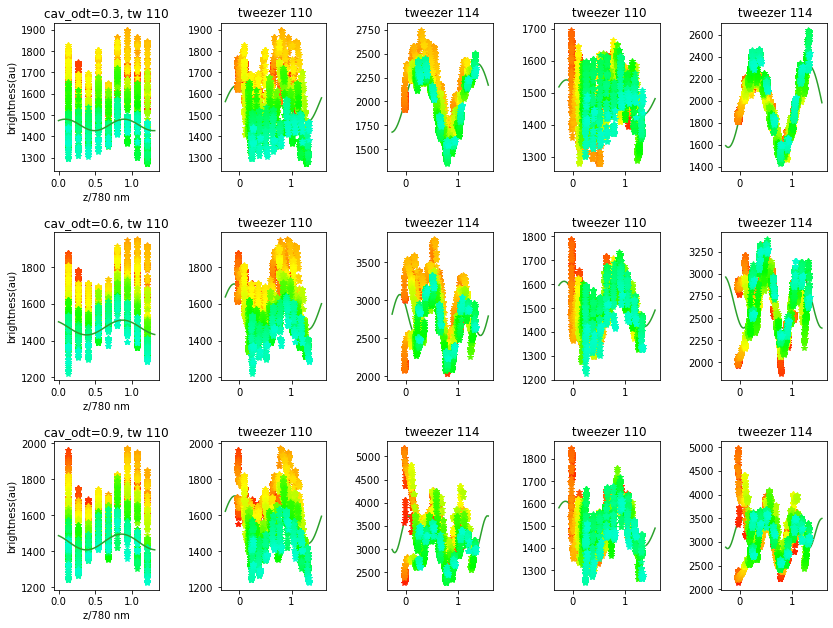

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colorsys

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
y_mag = 1 #13.64
x_mag = 2/7.5


tweezer_select = [5,7]




fig, axs = plt.subplots(len(cav_odt_att_list), 1+2*len(tweezer_select),  figsize=(12, 3*len(cav_odt_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:]):

        valid = ~(np.isnan(cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter]) |\
                  np.isnan(cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter]))
        if np.count_nonzero(valid)>4:
            popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                           cav_brightness_mean[valid,cav_odt_att_counter,tweezer_counter],\
                           sigma = cav_brightness_sigma[valid,cav_odt_att_counter,tweezer_counter],\
                           p0=[1000, 4000, 7, 0], maxfev = 10000)

            a0, b0, wavelength0, xshift0 = popt

        def func_cos2(x, xshift):
            return b0 + a0 * np.cos(4*np.pi/wavelength0*(x+xshift)) 
    #     print('________________________')
        for loop in range(loop_start,loop_end):
            color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
            if tweezer_counter == tweezer_select[0]:
#                     axs[cav_odt_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'.', color =f'C{tweezer_counter:01d}',markersize=0.5)
                axs[cav_odt_att_counter,0].plot(x_mag * (np.array(pzt_para_list)-5) ,\
                                             y_mag * cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter,loop],\
                                             '*', label= f'{tweezer_freq_list[tweezer_counter]}', color = color);


        if tweezer_counter == tweezer_select[0]: 
            axs[cav_odt_att_counter,0].set_xlabel('z/780 nm')
            axs[cav_odt_att_counter,0].set_ylabel('brightness(au)')
            axs[cav_odt_att_counter,0].set_title(f'cav_odt={cav_odt_att_list[cav_odt_att_counter]}, tw {tweezer_freq}'\
#                f'| a0={a0:.2f}, b0={b0:.2f}'\
            );

            if np.count_nonzero(valid)>4:
                xx = np.arange(5,10,0.1)
                yy = func_cos(xx,a0,b0,wavelength0,xshift0)
                axs[cav_odt_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'-', color ='C2')


        shifted_pzt = shifted_pzt_para_simple[:, loop_start:loop_end].flatten()

        cav_b = cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()
        cav_b_sigma = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()


        if np.count_nonzero(~np.isnan(cav_b))>4:
            popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                           cav_b[~np.isnan(cav_b)],\
        #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
                           p0=[1000, 4000, 7, 0], maxfev = 100000)

            a0, b0, wavelength0, xshift0 = popt
            xx = np.arange(4,11,0.1)
            yy = func_cos(xx,a0,b0,wavelength0,xshift0)


        if (tweezer_counter in tweezer_select): 
            if np.count_nonzero(~np.isnan(cav_b))>4:
                axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

            axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
#                 f'a0={a0:.2f}, b0={b0:.2f}'\
                                                                                     );

#                 divider = make_axes_locatable(axs[cav_odt_att_counter,1])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 fig.colorbar(im, cax=cax, orientation='vertical')
            for loop in range(loop_start,loop_end):
                color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_para_simple[:,loop]-5),\
                                                  y_mag*cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter,loop],\
                                                  '*', color = color);



        cav_b = cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()
        cav_b_sigma = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()


        if np.count_nonzero(~np.isnan(cav_b))>4:
            popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                           cav_b[~np.isnan(cav_b)],\
        #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
                           p0=[1000, 4000, 7, 0], maxfev = 100000)

            a0, b0, wavelength0, xshift0 = popt
            xx = np.arange(4,11,0.1)
            yy = func_cos(xx,a0,b0,wavelength0,xshift0)


        if (tweezer_counter in tweezer_select): 
            if np.count_nonzero(~np.isnan(cav_b))>4:
                axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

            axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
#                                                                                           f', a0={a0:.2f}, b0={b0:.2f}'\
                                                                                     );

#                 divider = make_axes_locatable(axs[cav_odt_att_counter,1])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 fig.colorbar(im, cax=cax, orientation='vertical')
            for loop in range(loop_start,loop_end):
                color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_para_simple[:,loop]-5),\
                                                  y_mag*cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter,loop],\
                                                  '*', color = color);




In [10]:
with open('3-27_fit_dict_tweezer_att=7_mol_att=5.pkl', 'rb') as f:
    fit_dict = pickle.load(f)
    
    
    
print(fit_dict[f"tweezer_counter=0"])

            

[array([632.25183013,  10.02488706]), array([[43.15238756,  1.35180577],
       [ 1.35180577,  0.0436847 ]])]


In [11]:
# For each tweezer and each cav_odt_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X cav_odt_att
# PLOT: brightness X mol_freq, diff pzt settings.
plot_true = False

stark_mag = 13.5
def stark_shift(cicero):
    return -210 + 2*(6.69*cicero+42.8)
int_mag = 0.0001
def func(x, a, center):
    return  a / (x-center)**2

ac_compensation = 6.5
cropped_loop_number = loop_end-loop_start

starkshift_const_freq = np.zeros((len( cav_odt_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))
sigma_starkshift_const_freq = np.zeros((len( cav_odt_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))


for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list[:], range(len(cav_odt_att_list[:]))):

    for tweezer_freq, tweezer_counter in zip(tweezer_freq_list[:], range(len(tweezer_freq_list[:]))):
        print('__________________________')
        print(f'cav_odt = {cav_odt_att}, tw = {tweezer_freq}')
        if plot_true :
            fig, ax = plt.subplots(1,1,  figsize=(8, 6))
            ax.set_xlabel('AC Stark shift(MHz)')
            ax.set_ylabel('brightness(AU)')
            ax.set_title(f'cav_odt_att={cav_odt_att}, tw#={tweezer_freq_list[tweezer_counter]}')    
        for loop in range(loop_start, loop_end):
        
            mask = bg_brightness_mov_avg[loop] > 400
            popt, pcov = fit_dict[f"tweezer_counter={tweezer_counter}"]
            a_nocav, center_nocav = popt
            
            sigma_center_nocav = np.sqrt(pcov[1,1])
            sigma_a_nocav = np.sqrt(pcov[0,0])
            if plot_true :
                ax.plot(np.arange(-50,10,1),func(np.arange(-50,10,1), a_nocav, center_nocav), linestyle='-', c = 'black')
                   

            for pzt_counter in range(0, len(pzt_para_list)):
            
                colorratio = (shifted_pzt_para_simple[pzt_counter, loop]-\
                            np.min(shifted_pzt_para_simple))/\
                            (np.max(shifted_pzt_para_simple)-\
                            np.min(shifted_pzt_para_simple))
                color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)      
                
                brightness_temp = int_mag * cav_brightness_mov_avg[pzt_counter, cav_odt_att_counter, tweezer_counter, loop]
                

                sigma_brightness_temp = int_mag * cav_brightness_mov_sigma[pzt_counter, cav_odt_att_counter, tweezer_counter, loop]

                starkshift_temp = - np.sqrt(a_nocav / brightness_temp) + center_nocav - stark_shift(mol_freq) + ac_compensation
#                     print(starkshift_temp)
                dBdS = 2*brightness_temp/np.sqrt(a_nocav / brightness_temp)
                sigma_starkshift_temp = sigma_brightness_temp / dBdS

                starkshift_const_freq[cav_odt_att_counter, tweezer_counter, pzt_counter, loop] = \
                starkshift_temp
                sigma_starkshift_const_freq[cav_odt_att_counter, tweezer_counter, pzt_counter, loop] = \
                sigma_starkshift_temp
                
                if plot_true == True :
                    if (loop%10 == 0):
                        ax.errorbar(stark_shift(mol_freq), brightness_temp, \
                        yerr = sigma_brightness_temp,  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
                        

        if plot_true == True :
            ax.set_ylim([0, 3*int_mag * np.amax(bg_brightness_mean)])

    #         ax.legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.tick_params(axis='y')
            plt.savefig(f'cav_odt_att={cav_odt_att}, tw#={tweezer_freq_list[tweezer_counter]}.png',dpi=1000)

__________________________
cav_odt = 0.3, tw = 100
__________________________
cav_odt = 0.3, tw = 102
__________________________
cav_odt = 0.3, tw = 104
__________________________
cav_odt = 0.3, tw = 106
__________________________
cav_odt = 0.3, tw = 108
__________________________
cav_odt = 0.3, tw = 110
__________________________
cav_odt = 0.3, tw = 112
__________________________
cav_odt = 0.3, tw = 114
__________________________
cav_odt = 0.3, tw = 116
__________________________
cav_odt = 0.3, tw = 118
__________________________
cav_odt = 0.3, tw = 120
__________________________
cav_odt = 0.6, tw = 100
__________________________
cav_odt = 0.6, tw = 102
__________________________
cav_odt = 0.6, tw = 104
__________________________
cav_odt = 0.6, tw = 106
__________________________
cav_odt = 0.6, tw = 108
__________________________
cav_odt = 0.6, tw = 110
__________________________
cav_odt = 0.6, tw = 112
__________________________
cav_odt = 0.6, tw = 114
__________________________
cav_

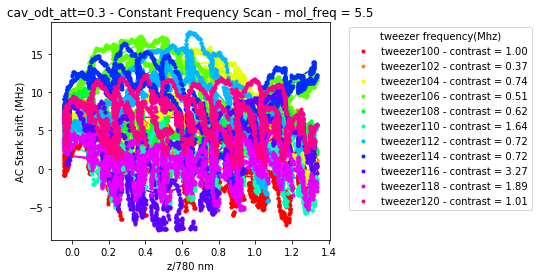

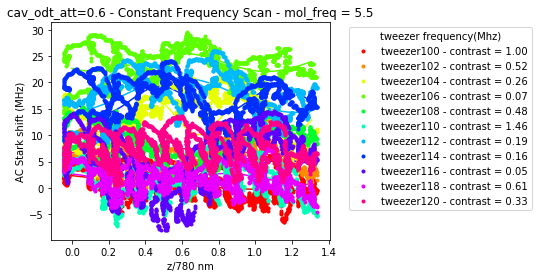

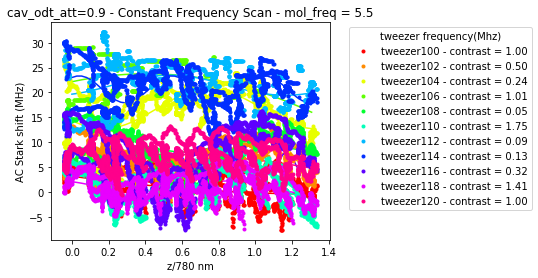

In [12]:
# AC Stark shift vs z position for diff cav_odt_att, all tweezers
# GRID: cav_odt_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)
import pickle
def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 


contrast_guess = np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))

x_mag = 2/7.5

for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list, range(len(cav_odt_att_list))):

    fig, ax = plt.subplots(1, 1,  figsize=(5, 4))
    for tweezer_counter in range(len(tweezer_freq_list)):

#         mask = ~np.isnan(starkshift[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten())

        mask = np.logical_and( \
                 starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()>-8,
                 sigma_starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()<9)
        popt, pcov = curve_fit(func_cos, shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask], \
                               starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
#                                sigma = sigma_starkshift_const_freq[cav_odt_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                               p0=[1, 1, 7, 0], maxfev = 100000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[cav_odt_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[cav_odt_att_counter, tweezer_counter] = b
        wavelength_fit[cav_odt_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[cav_odt_att_counter, tweezer_counter] = contrast_fit[cav_odt_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[cav_odt_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[cav_odt_att_counter, tweezer_counter] = np.sqrt(sigma_wavelength**2 \
        + 4*np.mean(sigma_starkshift_const_freq[cav_odt_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask])**2)

        if tweezer_counter == 0 or tweezer_counter == 10:
            average_fit[cav_odt_att_counter, tweezer_counter] = np.mean(starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask])
            sigma_average_fit[cav_odt_att_counter, tweezer_counter] = np.std(starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask])

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)

        if cav_odt_att_counter == 0:
            output_dict = {}
            output_dict["pzt_pos"] = x_mag * (shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask]-5)
            output_dict["stark_shift"] = starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
            output_dict["sigma_stark_shift"] = sigma_starkshift_const_freq[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
            f = open(f"trap_starkshift_vs_z - tweezer{tweezer_freq_list[tweezer_counter]}.pkl","wb")
            pickle.dump(dict,f)
            f.close()

        ax.plot(x_mag * (xx-5),yy,'-', color = color)
        ax.set_xlabel('z/780 nm')
        ax.set_ylabel('AC Stark shift (MHz)')
        ax.set_title(f'cav_odt_att={cav_odt_att} - Constant Frequency Scan - mol_freq = {mol_freq}')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        ax.errorbar(x_mag * (shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask]-5),\
           starkshift_const_freq[ cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
#          yerr = y_mag * sigma_starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],uplims=True, lolims=True, \
                                         label= f'tweezer{tweezer_freq_list[tweezer_counter]} - contrast = {np.abs(a/b):.2f}', color = color,ls='',marker = '.')
        ax.legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
#         contrast_guess[cav_odt_att_counter, tweezer_counter] = (np.max(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:])-np.min(starkshift_const_freq[mol_freq_counter,cav_odt_att_counter, tweezer_counter, :,:]))/\
#          (np.max(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:])+np.min(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:]))
        plt.savefig(f'Constant Frequency Scan - cav_odt_att = {cav_odt_att}- mol_freq = {mol_freq}.png',dpi=1000)


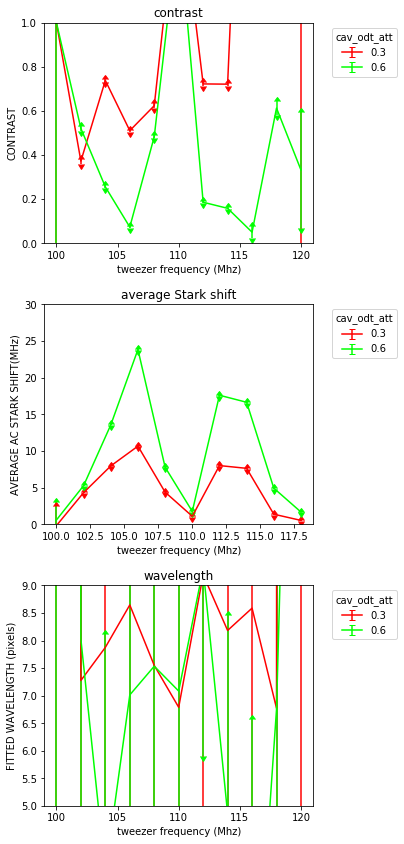

In [13]:



fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list[:-1], range(len(cav_odt_att_list)-1)):
    color = colorsys.hsv_to_rgb(cav_odt_att_counter/len(cav_odt_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,1])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list, contrast_fit[cav_odt_att_counter, :], \
                                         yerr = sigma_contrast_fit[cav_odt_att_counter, :], \
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,30])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[:-1], average_fit[cav_odt_att_counter,:-1],\
                                         yerr = sigma_average_fit[cav_odt_att_counter, :-1],\
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([5,9])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[:], wavelength_fit[ cav_odt_att_counter, :],\
                                         yerr = sigma_wavelength_fit[cav_odt_att_counter, :],\
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Constant Frequency Scan - cav_odt_att = {cav_odt_att} - Tweezers0.png',dpi=1000)

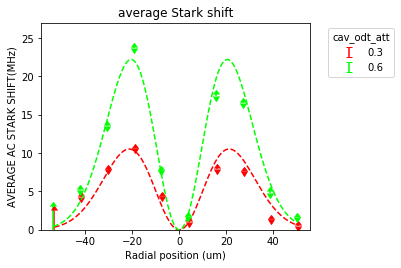

In [15]:
R_mag = 5.75
radial_dat_out_list = [["01_Radial_Position_dat(um)","01_Radial_Stark_shift_dat(MHz)","01_sigma_Radial_Stark_shift_dat(MHz)"]]
radial_fit_out_list = [["01_Radial_Position_fit(um)","01_Radial_Stark_shift_fit(MHz)"]]

def func_TEM01(x, A, waist, center):
    return A * (x-center)**2 * np.exp(-2 * (x-center)**2 / waist**2)

fig, ax = plt.subplots(1,1,  figsize=(5,4))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list[:-1], range(len(cav_odt_att_list)-1)):
    color = colorsys.hsv_to_rgb(cav_odt_att_counter/len(cav_odt_att_list),1,1)

    ax.set_xlabel('Radial position (um)')
    ax.set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax.set_ylim([0,27])
    ax.set_title(f'average Stark shift')
    popt, pcov = curve_fit(func_TEM01, tweezer_freq_list[:-1], \
                               average_fit[cav_odt_att_counter,:-1],\
                               sigma = sigma_average_fit[cav_odt_att_counter, :-1],\
                               p0=[10, 5, 109], maxfev = 10000)
    A, waist, center = popt
    sigma_A, sigma_waist, sigma_center = np.sqrt(pcov.diagonal())
        
    ax.errorbar((tweezer_freq_list[:-1]-center)*R_mag, average_fit[cav_odt_att_counter,:-1],\
                                         yerr = sigma_average_fit[cav_odt_att_counter, :-1],\
                  label = f'{cav_odt_att}',c=color, uplims=True, lolims=True, ls = '')
    xx = np.arange(100,118,0.1)
    yy = func_TEM01(xx, A, waist, center)
    ax.plot((xx-center)*R_mag, yy, '--', color = color)
    if cav_odt_att_counter == 1: 
        for ii in range(10):
            radial_dat_out_list.append([(tweezer_freq_list[ii]-center)*R_mag, average_fit[cav_odt_att_counter,ii], sigma_average_fit[cav_odt_att_counter,ii]])
        for ii in range(len(xx)):
            radial_fit_out_list.append([(xx[ii]-center)*R_mag, yy[ii]])

ax.legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Constant Frequency Scan - TEM01 - radial.png',dpi=1000)

import csv
file_name = 'figure-3b_01_data_high_field.txt'
# dat_file_path = Path(save_data_dir, file_name)
with open(file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_dat_out_list:
        csv_writer.writerow(row)
        
file_name = 'figure-3b_01_fit_high_field.txt'
# dat_file_path = Path(save_data_dir, file_name)
with open(file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_fit_out_list:
        csv_writer.writerow(row)
# import pickle
# output_dict = {}
# output_dict['Tweezer_freq'] = tweezer_freq_list[:]
# output_dict["avg_stark_shift"] = average_fit[cav_odt_att_counter,:]
# output_dict["sigma_avg_stark_shift"] =sigma_average_fit[cav_odt_att_counter, :]
# f = open("TEM01trap_starkshift_vs_r.pkl","wb")
# pickle.dump(dict,f)
# f.close()

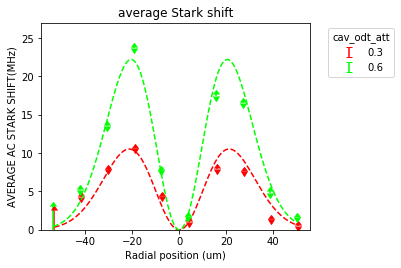

In [16]:
R_mag = 5.75
radial_dat_out_list = [["01_Radial_Position_dat(um)","01_Radial_Stark_shift_dat(MHz)","01_sigma_Radial_Stark_shift_dat(MHz)"]]
radial_fit_out_list = [["01_Radial_Position_fit(um)","01_Radial_Stark_shift_fit(MHz)"]]

def func_TEM01(x, A, waist, center):
    return A * (x-center)**2 * np.exp(-2 * (x-center)**2 / waist**2)

fig, ax = plt.subplots(1,1,  figsize=(5,4))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list[:-1], range(len(cav_odt_att_list)-1)):
    color = colorsys.hsv_to_rgb(cav_odt_att_counter/len(cav_odt_att_list),1,1)

    ax.set_xlabel('Radial position (um)')
    ax.set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax.set_ylim([0,27])
    ax.set_title(f'average Stark shift')
    popt, pcov = curve_fit(func_TEM01, tweezer_freq_list[:-1], \
                               average_fit[cav_odt_att_counter,:-1],\
                               sigma = sigma_average_fit[cav_odt_att_counter, :-1],\
                               p0=[10, 5, 109], maxfev = 10000)
    A, waist, center = popt
    sigma_A, sigma_waist, sigma_center = np.sqrt(pcov.diagonal())
        
    ax.errorbar((tweezer_freq_list[:-1]-center)*R_mag, average_fit[cav_odt_att_counter,:-1],\
                                         yerr = sigma_average_fit[cav_odt_att_counter, :-1],\
                  label = f'{cav_odt_att}',c=color, uplims=True, lolims=True, ls = '')
    xx = np.arange(100,118,0.1)
    yy = func_TEM01(xx, A, waist, center)
    ax.plot((xx-center)*R_mag, yy, '--', color = color)
    if cav_odt_att_counter == 0: 
        for ii in range(10):
            radial_dat_out_list.append([(tweezer_freq_list[ii]-center)*R_mag, average_fit[cav_odt_att_counter,ii], sigma_average_fit[cav_odt_att_counter,ii]])
        for ii in range(len(xx)):
            radial_fit_out_list.append([(xx[ii]-center)*R_mag, yy[ii]])

ax.legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Constant Frequency Scan - TEM01 - radial.png',dpi=1000)

import csv
file_name = 'figure-3b_01_data_low_field.txt'
# dat_file_path = Path(save_data_dir, file_name)
with open(file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_dat_out_list:
        csv_writer.writerow(row)
        
file_name = 'figure-3b_01_fit_low_field.txt'
# dat_file_path = Path(save_data_dir, file_name)
with open(file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for row in radial_fit_out_list:
        csv_writer.writerow(row)
# import pickle
# output_dict = {}
# output_dict['Tweezer_freq'] = tweezer_freq_list[:]
# output_dict["avg_stark_shift"] = average_fit[cav_odt_att_counter,:]
# output_dict["sigma_avg_stark_shift"] =sigma_average_fit[cav_odt_att_counter, :]
# f = open("TEM01trap_starkshift_vs_r.pkl","wb")
# pickle.dump(dict,f)
# f.close()

7.5 pzt_para = 780nm = 3.75 pixel  -> 1 pixel = 0.208 micron

-> tweezer 1Mhz = 27.65 pixels = 5.75 micron

